In [1]:
# Imports
from os import chdir
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as dd
import pandas as pd
from IPython.display import display, Markdown

In [3]:
# Move up two directories, to project base directory
chdir("..\\..")

In [ ]:
# Import data
df_games = pd.read_parquet("data\\store_info.parquet")
df_genres = pd.read_parquet("data\\genres.parquet")
df_categories = pd.read_parquet("data\\categories.parquet")

ddf_reviews = dd.read_parquet("data\\reviews.parquet\\")
ddf_reviews = ddf_reviews.rename(columns={"voted_up": "is_game_recommended"})
ddf_reviews["language"] = ddf_reviews["language"].astype("category")
df_reviews = ddf_reviews.compute()
ddf_reviews = dd.from_pandas(df_reviews)

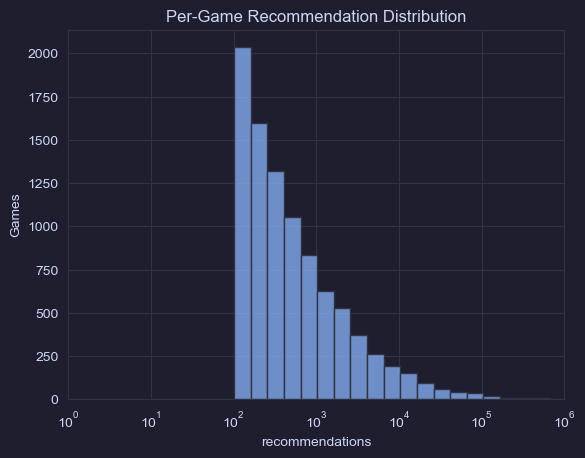

In [5]:
sns.histplot(df_games, x="recommendations", bins="doane", log_scale=(True, False))
plt.ylabel("Games")
plt.xlabel("recommendations")
plt.xlim(1, 10**6)
plt.title("Per-Game Recommendation Distribution")
plt.show()

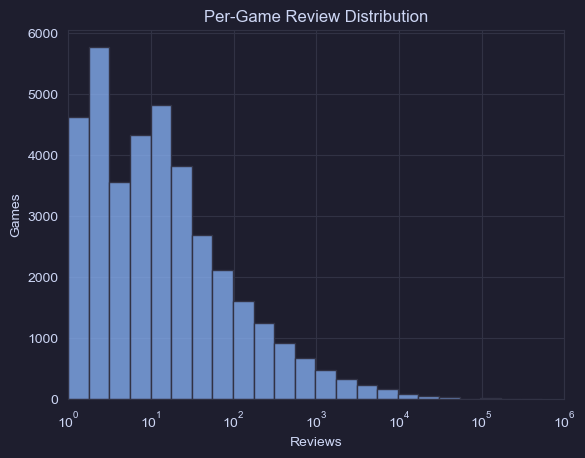

In [6]:
sns.histplot(
    df_reviews["steam_appid"].value_counts().reset_index(),
    x="count",
    bins="doane",
    log_scale=(True, False),
)
plt.ylabel("Games")
plt.xlabel("Reviews")
plt.xlim((1, 10**6))
plt.title("Per-Game Review Distribution")
plt.show()

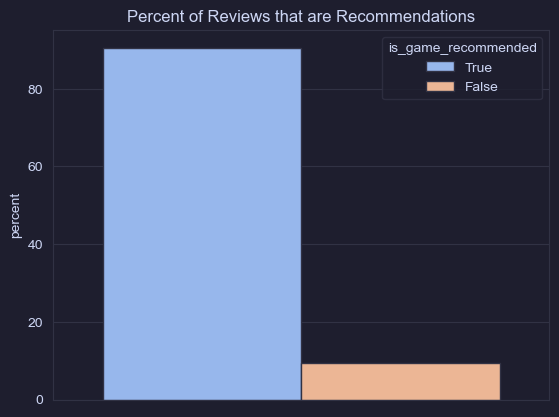

In [7]:
sns.countplot(
    df_reviews,

    x=np.zeros(len(df_reviews)),

    hue="is_game_recommended",
    hue_order=[True, False],
    stat="percent",
)

plt.gca().xaxis.set_visible(False)

plt.title("Percent of Reviews that are Recommendations")
plt.show()

In [ ]:
df_games = df_games.merge(
    pd.DataFrame(df_reviews["steam_appid"].value_counts()).rename(
        columns={"count": "review_count"}
    ),
    on="steam_appid",
)

In [ ]:
df_games["review_count"]

steam_appid
1000000      6
1000080    107
1000130      6
1000280      2
1000440     35
          ... 
999480       4
999640      30
999860      67
999890       2
999990       3
Name: review_count, Length: 37588, dtype: int64

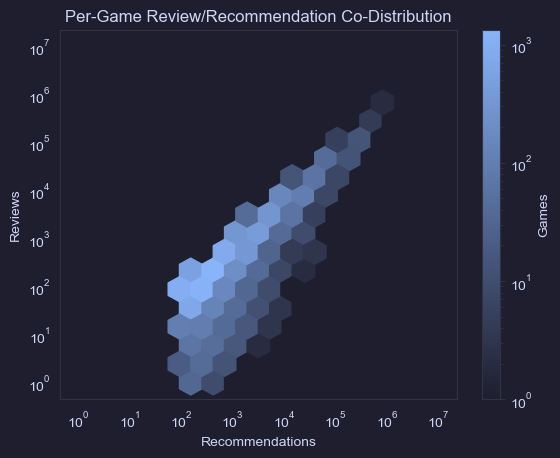

In [10]:
df_recommended_games = df_games[df_games["recommendations"] > 0]

plt.hexbin(
    x=df_recommended_games["recommendations"],
    y=df_recommended_games["review_count"],
    xscale="log",
    yscale="log",
    bins="log",
    gridsize=16,
    # cmap='Blues',
    extent=(0, 7, 0, 7),
)
plt.colorbar(label="Games")
plt.xlabel("Recommendations")
plt.ylabel("Reviews")
plt.title("Per-Game Review/Recommendation Co-Distribution")
plt.grid(False)
plt.show()

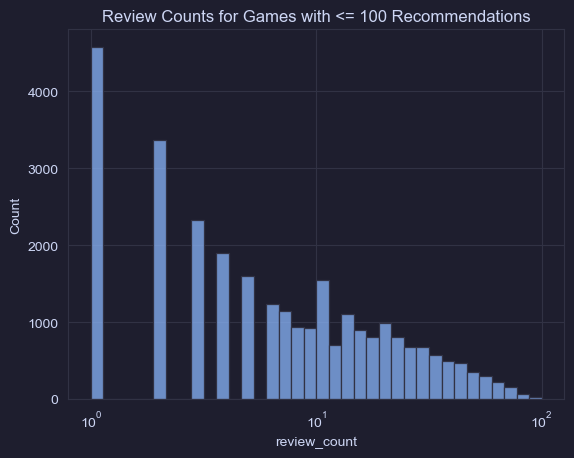

In [11]:
sns.histplot(
    df_games[df_games["recommendations"] < 100], x="review_count", log_scale=(True)
)
plt.title("Review Counts for Games with <= 100 Recommendations")
plt.show()

In [12]:
df_genre_counts = (
    pd.DataFrame(df_genres.sum())
    .rename(columns={0: "Count"})
    .sort_values("Count", ascending=False)
)
df_genre_counts["Percent"] = df_genre_counts["Count"] / len(df_genres) * 100
df_genre_counts_gmap = np.log10(df_genre_counts)
df_genre_counts_gmap["Count"] = (
    2
    * (df_genre_counts_gmap["Count"] - df_genre_counts_gmap["Count"].min())
    / (df_genre_counts_gmap["Count"].max() - df_genre_counts_gmap["Count"].min())
    - 1
)
df_genre_counts_gmap["Percent"] = df_genre_counts_gmap["Percent"] / 2
df_genre_counts.style.background_gradient(
    cmap="viridis", gmap=df_genre_counts_gmap, axis=None, vmax=1, vmin=-1
).format(precision=2)

,Count,Percent
Indie,55794,95.43
Casual,25836,44.19
Action,24907,42.60
Adventure,23270,39.80
Simulation,10690,18.28
Strategy,10580,18.10
RPG,9901,16.93
Early Access,5767,9.86
Free To Play,4684,8.01
Sports,2222,3.80


In [13]:
df_category_counts = (
    pd.DataFrame(df_categories.sum())
    .rename(columns={0: "Count"})
    .sort_values("Count", ascending=False)
)
df_category_counts["Percent"] = df_category_counts["Count"] / len(df_categories) * 100
df_category_counts_gmap = np.log10(df_category_counts)
df_category_counts_gmap["Count"] = (
    2
    * (df_category_counts_gmap["Count"] - df_category_counts_gmap["Count"].min())
    / (df_category_counts_gmap["Count"].max() - df_category_counts_gmap["Count"].min())
    - 1
)
df_category_counts_gmap["Percent"] = df_category_counts_gmap["Percent"] / 2
df_category_counts.style.background_gradient(
    cmap="viridis", gmap=df_category_counts_gmap, axis=None, vmax=1, vmin=-1
).format(
    precision=2,
)

,Count,Percent
Single-player,56243,96.20
Family Sharing,44764,76.57
Steam Achievements,28944,49.51
Steam Cloud,14172,24.24
Full controller support,13821,23.64
Multi-player,9377,16.04
Partial Controller Support,7646,13.08
Steam Trading Cards,7008,11.99
PvP,6028,10.31
Steam Leaderboards,5317,9.09


In [ ]:
df_reviews_per_author = pd.DataFrame(
    ddf_reviews["author_steamid"].value_counts().compute()
)

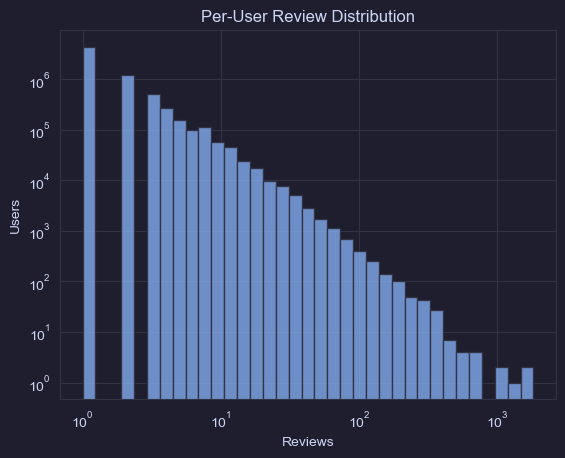

In [ ]:
sns.histplot(df_reviews_per_author, x="count", bins="doane", log_scale=(True, False))
plt.yscale("log")
plt.ylabel("Users")
plt.xlabel("Reviews")
plt.title("Per-User Review Distribution")
plt.show()

In [ ]:
df_reviews["author_playtime_since_review"] = (
    df_reviews["author_playtime_forever"] - df_reviews["author_playtime_at_review"]
)
df_reviews["author_playtime_since_review_quotient"] = (
    df_reviews["author_playtime_forever"] / df_reviews["author_playtime_at_review"]
)

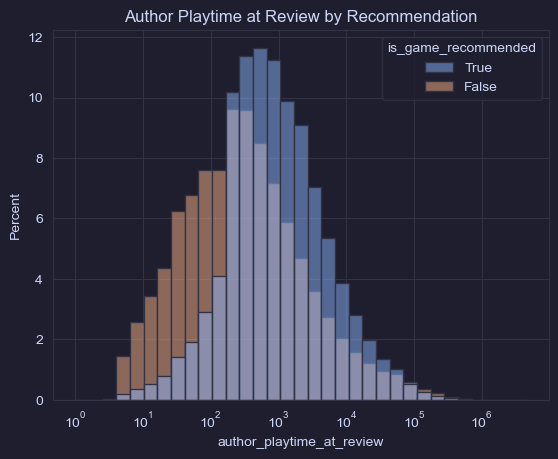

In [ ]:
sns.histplot(
    df_reviews,

    x="author_playtime_at_review",

    hue="is_game_recommended",

    bins="doane",

    stat="percent",
    hue_order=[True, False],

    common_norm=False,

    log_scale=(True, False),
)

plt.title("Author Playtime at Review by Recommendation")

plt.show()

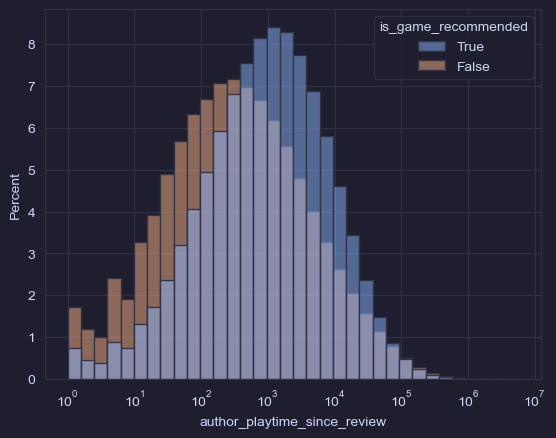

In [ ]:
sns.histplot(
    df_reviews,

    x="author_playtime_since_review",

    hue="is_game_recommended",

    bins="doane",

    stat="percent",
    hue_order=[True, False],

    common_norm=False,

    log_scale=(True, False),
)

plt.show()

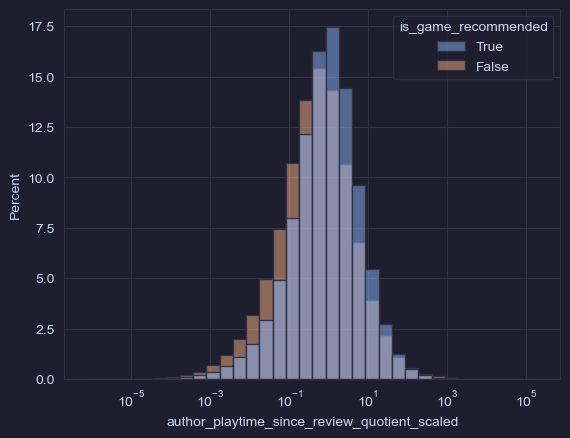

In [ ]:
df_reviews["author_playtime_since_review_quotient_scaled"] = (
    df_reviews["author_playtime_forever"] / df_reviews["author_playtime_at_review"]
) - 1


sns.histplot(
    df_reviews,

    x="author_playtime_since_review_quotient_scaled",

    hue="is_game_recommended",
    hue_order=[True, False],

    bins="doane",
    stat="percent",

    common_norm=False,

    log_scale=(True, False),
)

plt.show()

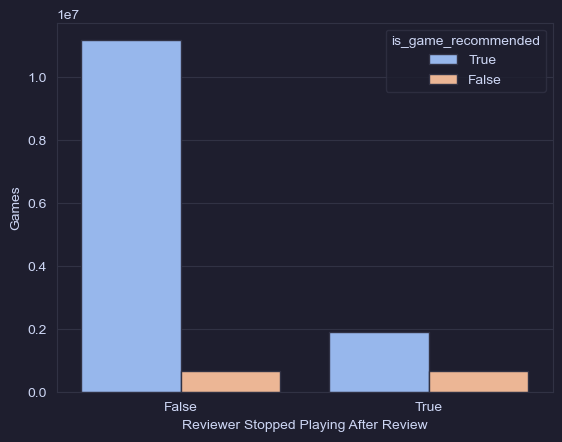

In [ ]:
df_reviews["dropped_after_review"] = (
    df_reviews["timestamp_created"] >= df_reviews["author_last_played"]
)


sns.countplot(
    df_reviews,

    x="dropped_after_review",

    hue="is_game_recommended",
    hue_order=[True, False],
)

plt.ylabel("Games")

plt.xlabel("Reviewer Stopped Playing After Review")

plt.show()

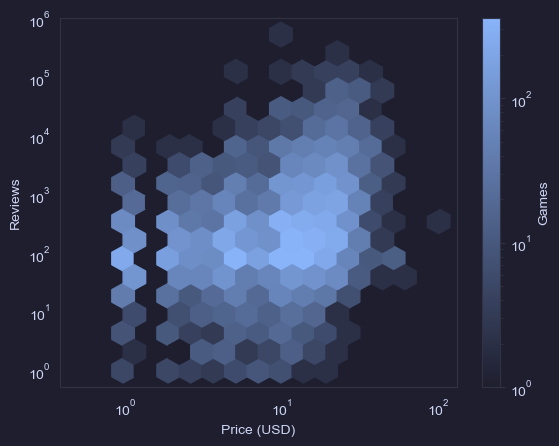

In [ ]:
df_recommended_games_not_free = df_recommended_games[df_recommended_games["price"] > 0]

plt.hexbin(
    x=df_recommended_games_not_free["price"],
    y=df_recommended_games_not_free["review_count"],
    xscale="log",
    yscale="log",
    bins="log",
    gridsize=16,
    # cmap='Blues',
)
plt.colorbar(label="Games")
plt.xlabel("Price (USD)")
plt.ylabel("Reviews")
plt.grid(False)
plt.show()

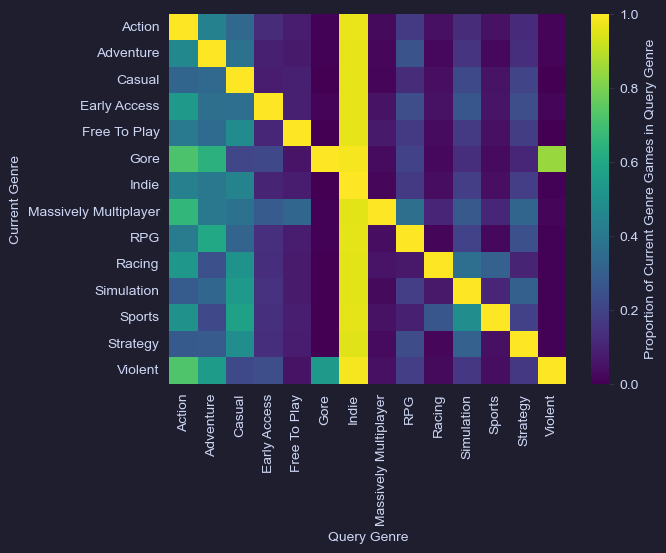

In [22]:
df_genre_average = pd.DataFrame()
rows_to_drop = []
for genre in df_genres.columns:
    if df_genres[genre].sum() >= 100:
        df_genre_average[genre] = df_genres[df_genres[genre] == True].mean()
    else:
        rows_to_drop.append(genre)

for row in rows_to_drop:
    df_genre_average = df_genre_average.drop(row)

# df_genre_average = df_genre_average.drop('genres: Indie', axis=0)
# df_genre_average = df_genre_average.drop('genres: Indie', axis=1)

df_genre_average = df_genre_average.transpose()

sns.heatmap(
    df_genre_average,
    vmin=0,
    vmax=1,
    cmap="viridis",
    cbar_kws={"label": "Proportion of Current Genre Games in Query Genre"},
)
plt.xlabel("Query Genre")
plt.ylabel("Current Genre")
plt.show()

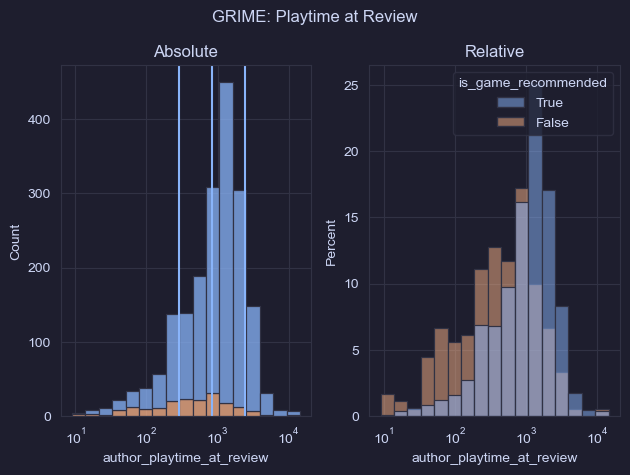

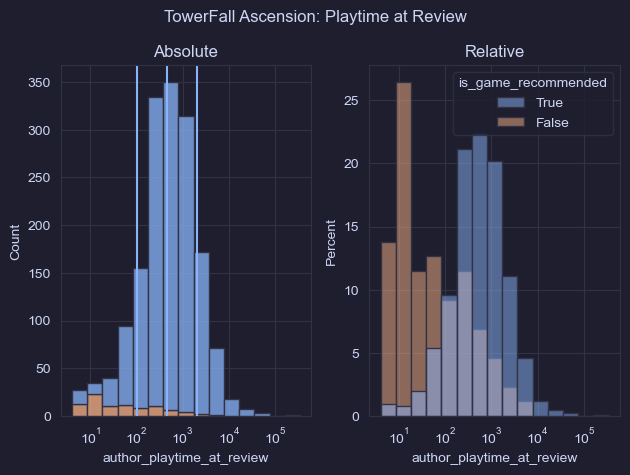

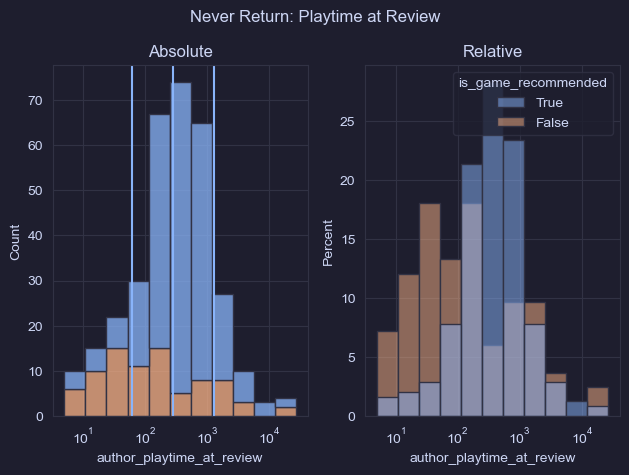

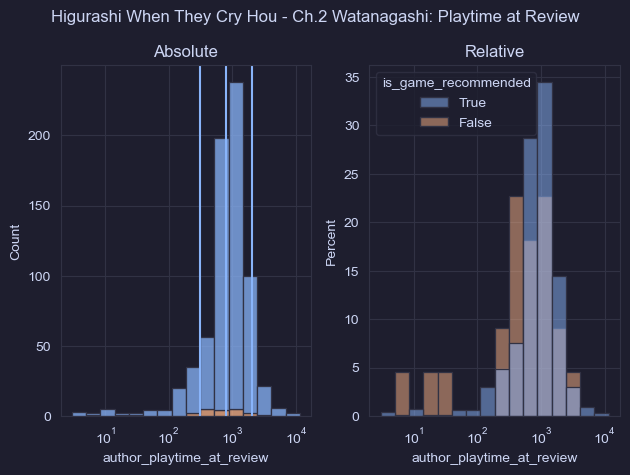

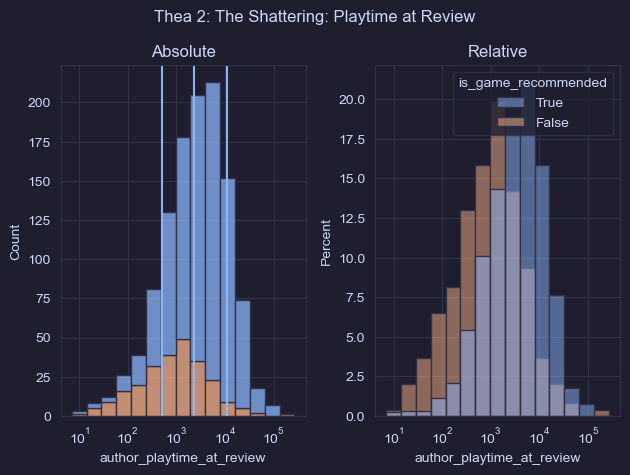

In [24]:
for appid in (
    df_games[df_games["recommendations"] > 1000].sample(5, random_state=42).index
):
    fig, ax = plt.subplots(ncols=2, nrows=1, sharex=True)
    sns.histplot(
        df_reviews[df_reviews["steam_appid"] == appid],
        x="author_playtime_at_review",
        hue="is_game_recommended",
        hue_order=[True, False],
        bins="doane",
        multiple="stack",
        log_scale=(True, False),
        ax=ax[0],
    )
    ax[0].axvline(
        10
        ** np.log10(
            df_reviews[df_reviews["steam_appid"] == appid]["author_playtime_at_review"]
        ).mean()
    )
    ax[0].axvline(
        10
        ** (
            np.log10(
                df_reviews[df_reviews["steam_appid"] == appid][
                    "author_playtime_at_review"
                ]
            ).mean()
            + np.log10(
                df_reviews[df_reviews["steam_appid"] == appid][
                    "author_playtime_at_review"
                ]
            ).std()
        )
    )
    ax[0].axvline(
        10
        ** (
            np.log10(
                df_reviews[df_reviews["steam_appid"] == appid][
                    "author_playtime_at_review"
                ]
            ).mean()
            - np.log10(
                df_reviews[df_reviews["steam_appid"] == appid][
                    "author_playtime_at_review"
                ]
            ).std()
        )
    )
    sns.histplot(
        df_reviews[df_reviews["steam_appid"] == appid],
        x="author_playtime_at_review",
        hue="is_game_recommended",
        hue_order=[True, False],
        bins="doane",
        stat="percent",
        common_norm=False,
        log_scale=(True, False),
        ax=ax[1],
    )
    ax[0].get_legend().remove()
    ax[0].set_title("Absolute")
    ax[1].set_title("Relative")
    fig.suptitle(f'{df_games.loc[appid, "name"]}: Playtime at Review')
    plt.tight_layout()
    plt.show()

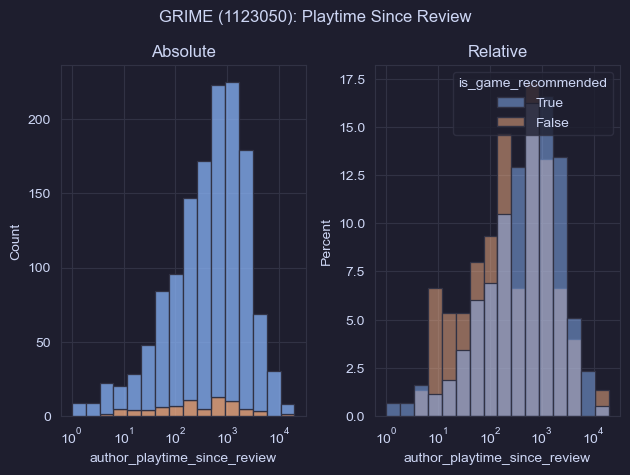

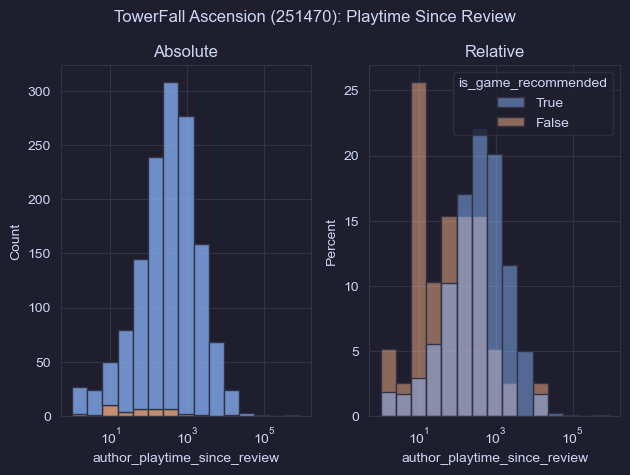

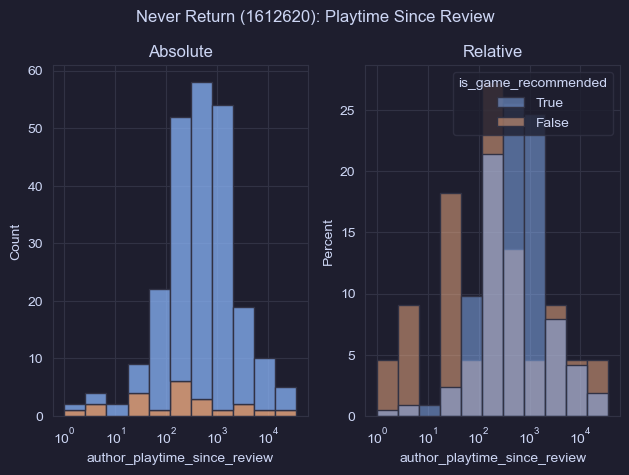

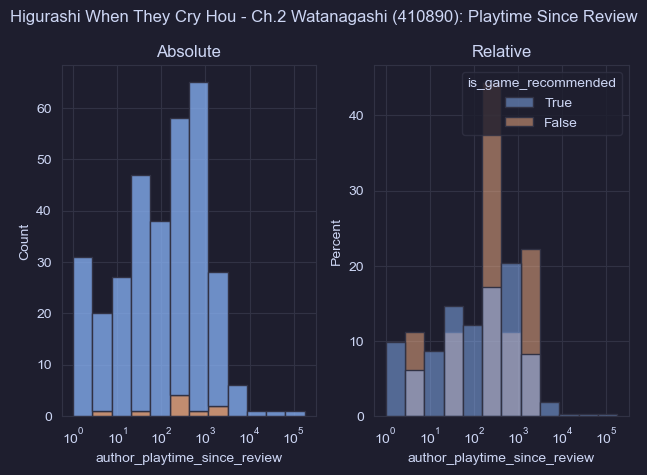

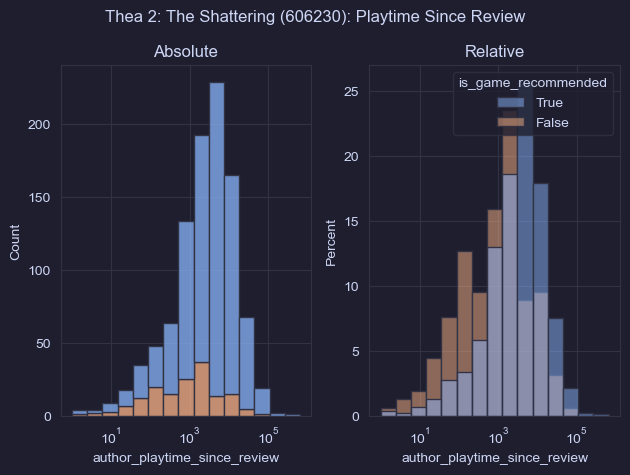

In [25]:
for appid in (
    df_games[df_games["recommendations"] > 1000].sample(5, random_state=42).index
):
    fig, ax = plt.subplots(ncols=2, nrows=1, sharex=True)
    sns.histplot(
        df_reviews[df_reviews["steam_appid"] == appid],
        x="author_playtime_since_review",
        hue="is_game_recommended",
        hue_order=[True, False],
        bins="doane",
        multiple="stack",
        log_scale=(True, False),
        ax=ax[0],
    )

    sns.histplot(
        df_reviews[df_reviews["steam_appid"] == appid],
        x="author_playtime_since_review",
        hue="is_game_recommended",
        hue_order=[True, False],
        bins="doane",
        stat="percent",
        common_norm=False,
        log_scale=(True, False),
        ax=ax[1],
    )
    ax[0].get_legend().remove()
    ax[0].set_title("Absolute")
    ax[1].set_title("Relative")
    fig.suptitle(f'{df_games.loc[appid, "name"]} ({appid}): Playtime Since Review')
    plt.tight_layout()
    plt.show()

In [26]:
for i, review in enumerate(
    df_reviews[
        (df_reviews["steam_appid"] == 1123050)
        & (df_reviews["is_game_recommended"] == False)
    ].sample(5, random_state=42)["review"]
):
    print(f"\nGRIME Negative Review {i}")
    display(Markdown(review))


GRIME Negative Review 0


The game came out 2 years ago, but the constant crashes are terribly depressing. The forums are full of people who are faced with this problem, but for some reason they don’t write about it in the reviews. I played 10 hours with crashes every half hour and eventually lost my save. I have the latest hardware, cyberpunk 144fps on ultra with all traces, so it’s clearly not a hardware issue


GRIME Negative Review 1


Arbitrary system of positive/negative reviews aside, this game is more of an "eh" than an unworthy product. However, I can't recommend this.

I actually tried to think hard about anything positive this game did, besides doing an impressively creative world building of earth creatures, toothy caverns, and still being an action-y platformer with the embraced metroidvania elements.

Unfortunately, the rock formations are but one of the cornerstones of why this game is feeling like it doesn't leave a noticeable scratch:
The story/lore isn't quite enticing, the characters only cause feelings of indifference, and overall the game just feels like it's designed with levels just sort of existing for the sake of being in places and to have some strange monstrosities to fight against. Which, again, do look quite unique.

I still hold my respect for the devs however, because it is a nice looking indie game, from not just the levels but also in how professional the UI seems to be crafted. It's just that I feel no real emotion out of this experience, and why I cannot recommend such a game when there are plenty enough of metroidvanias on the market that have also done their own thing be it by gameplay or  design choices.

If you like metroidvanias, I guess I'd recommend buying this on a sale at least, but I feel like the general experience was just not worth the full price.


GRIME Negative Review 2


So....... why does every single Metroidvania have to be dark souls these days. Why is every game made now Dark Souls. Blasphemous nailed it this does not. I would like one to come out that has a castle or a metroid in it...LOL. Seriously though this game just blows, sorry devs. I have played all of them, SOTN, Blasphemous, Ori and the Super Meatboy Forest..LOL (Super Meat Boy sucks to) and so on. well lets do the check list:
1. Is it boring yes
2. You have to find the stupid device to get that portion of the map. -boring and frustrating.
3. I just beat jawbone crab whatever - every boss battle so far you have to parry - Dark Souls 
4. Running over the long parts of an area until you don't get killed - Dark Souls
5. Just plain frustrating, meaning non-rewarding for the agony you have to go through. - Dark Souls
6. I spent the money so I am in.........Dark Souls
So to wrap it up, Dark Souls...lol. if you like boring, frustrating, wandering around in aimless areas, and looking for a map device, and you like  this metroidsoulsvania (but the only thing that represents the metroid and vania is the map) then this is the game for you. I was really pumped for this.. I am bummed. Looks like its Call of Duty and Dark Souls clones from here on in.
On a solid note the graphics are awesome. I normally don't ever leave reviews but I was so excited for this and it just falls in the same category as most others of it's kind.


GRIME Negative Review 3


There's a bug which makes me unable to beat the last boss


Jk I just suck at this game


GRIME Negative Review 4


The game started well, but after some time turned to half baked, poor man`s, Dark Souls wannabe. With tiring platforming.
And I love SoulsBornes.

In [27]:
for i, review in enumerate(
    df_reviews[
        (df_reviews["steam_appid"] == 1123050)
        & (df_reviews["is_game_recommended"] == False)
    ].sample(5, random_state=42)["review"]
):
    print(f"\nTowerFall Ascension Negative Review {i}")
    display(Markdown(review))


TowerFall Ascension Negative Review 0


The game came out 2 years ago, but the constant crashes are terribly depressing. The forums are full of people who are faced with this problem, but for some reason they don’t write about it in the reviews. I played 10 hours with crashes every half hour and eventually lost my save. I have the latest hardware, cyberpunk 144fps on ultra with all traces, so it’s clearly not a hardware issue


TowerFall Ascension Negative Review 1


Arbitrary system of positive/negative reviews aside, this game is more of an "eh" than an unworthy product. However, I can't recommend this.

I actually tried to think hard about anything positive this game did, besides doing an impressively creative world building of earth creatures, toothy caverns, and still being an action-y platformer with the embraced metroidvania elements.

Unfortunately, the rock formations are but one of the cornerstones of why this game is feeling like it doesn't leave a noticeable scratch:
The story/lore isn't quite enticing, the characters only cause feelings of indifference, and overall the game just feels like it's designed with levels just sort of existing for the sake of being in places and to have some strange monstrosities to fight against. Which, again, do look quite unique.

I still hold my respect for the devs however, because it is a nice looking indie game, from not just the levels but also in how professional the UI seems to be crafted. It's just that I feel no real emotion out of this experience, and why I cannot recommend such a game when there are plenty enough of metroidvanias on the market that have also done their own thing be it by gameplay or  design choices.

If you like metroidvanias, I guess I'd recommend buying this on a sale at least, but I feel like the general experience was just not worth the full price.


TowerFall Ascension Negative Review 2


So....... why does every single Metroidvania have to be dark souls these days. Why is every game made now Dark Souls. Blasphemous nailed it this does not. I would like one to come out that has a castle or a metroid in it...LOL. Seriously though this game just blows, sorry devs. I have played all of them, SOTN, Blasphemous, Ori and the Super Meatboy Forest..LOL (Super Meat Boy sucks to) and so on. well lets do the check list:
1. Is it boring yes
2. You have to find the stupid device to get that portion of the map. -boring and frustrating.
3. I just beat jawbone crab whatever - every boss battle so far you have to parry - Dark Souls 
4. Running over the long parts of an area until you don't get killed - Dark Souls
5. Just plain frustrating, meaning non-rewarding for the agony you have to go through. - Dark Souls
6. I spent the money so I am in.........Dark Souls
So to wrap it up, Dark Souls...lol. if you like boring, frustrating, wandering around in aimless areas, and looking for a map device, and you like  this metroidsoulsvania (but the only thing that represents the metroid and vania is the map) then this is the game for you. I was really pumped for this.. I am bummed. Looks like its Call of Duty and Dark Souls clones from here on in.
On a solid note the graphics are awesome. I normally don't ever leave reviews but I was so excited for this and it just falls in the same category as most others of it's kind.


TowerFall Ascension Negative Review 3


There's a bug which makes me unable to beat the last boss


Jk I just suck at this game


TowerFall Ascension Negative Review 4


The game started well, but after some time turned to half baked, poor man`s, Dark Souls wannabe. With tiring platforming.
And I love SoulsBornes.

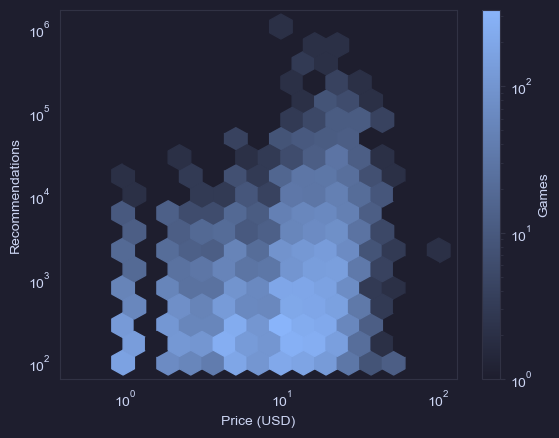

In [ ]:
df_recommended_games_not_free = df_recommended_games[df_recommended_games["price"] > 0]

plt.hexbin(
    x=df_recommended_games_not_free["price"],
    y=df_recommended_games_not_free["recommendations"],
    xscale="log",
    yscale="log",
    bins="log",
    # cmap='Blues',
    gridsize=16,
)
plt.colorbar(label="Games")
plt.xlabel("Price (USD)")
plt.ylabel("Recommendations")
plt.grid(False)
plt.show()

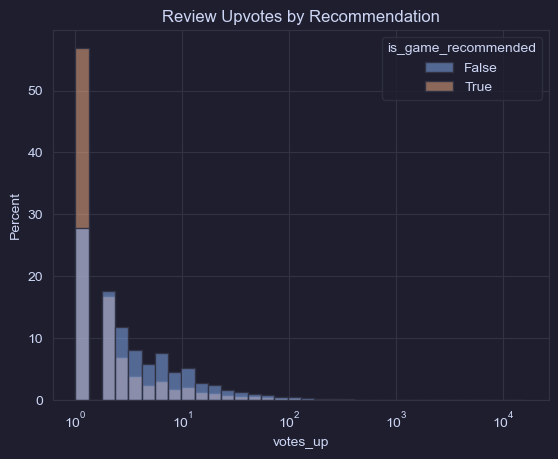

In [ ]:
sns.histplot(
    df_reviews,
    x="votes_up",
    hue="is_game_recommended",
    bins="doane",
    stat="percent",
    common_norm=False,
    log_scale=(True, False),
)
plt.title("Review Upvotes by Recommendation")
plt.show()

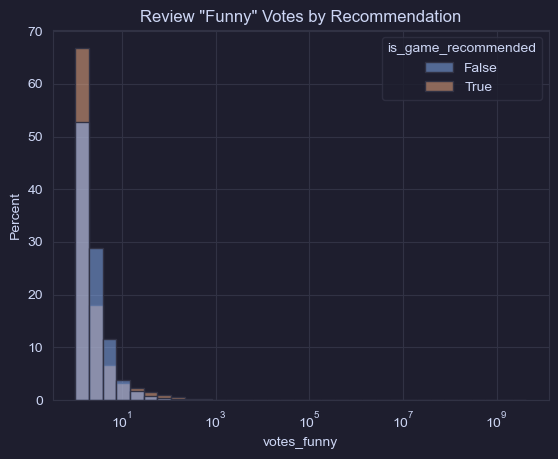

In [ ]:
sns.histplot(
    df_reviews,
    x="votes_funny",
    hue="is_game_recommended",
    bins="doane",
    stat="percent",
    common_norm=False,
    log_scale=(True, False),
)
plt.title('Review "Funny" Votes by Recommendation')
plt.show()

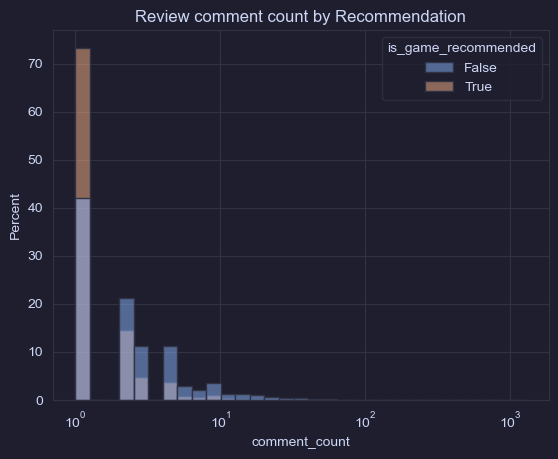

In [ ]:
sns.histplot(
    df_reviews,
    x="comment_count",
    hue="is_game_recommended",
    bins="doane",
    stat="percent",
    common_norm=False,
    log_scale=(True, False),
)
plt.title("Review comment count by Recommendation")
plt.show()

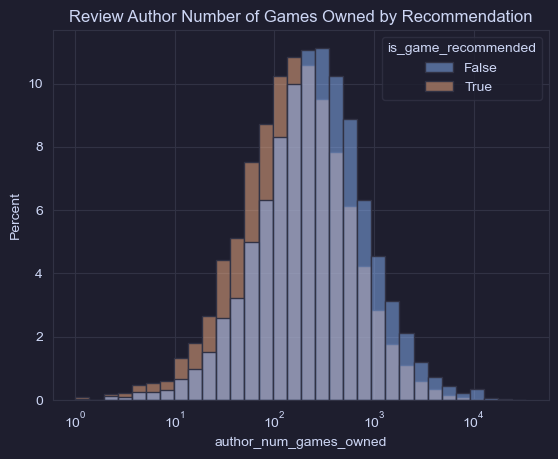

In [ ]:
sns.histplot(
    df_reviews,
    x="author_num_games_owned",
    hue="is_game_recommended",
    bins="doane",
    stat="percent",
    common_norm=False,
    log_scale=(True, False),
)
plt.title("Review Author Number of Games Owned by Recommendation")
plt.show()

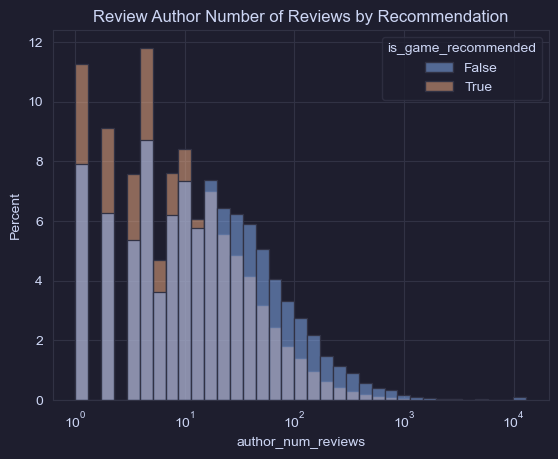

In [ ]:
sns.histplot(
    df_reviews,
    x="author_num_reviews",
    hue="is_game_recommended",
    bins="doane",
    stat="percent",
    common_norm=False,
    log_scale=(True, False),
)
plt.title("Review Author Number of Reviews by Recommendation")
plt.show()

In [ ]:
df_reviews = df_reviews.join(
    pd.DataFrame(
        df_reviews[["steam_appid"]].groupby("steam_appid").value_counts()
    ).rename(columns={"count": "reviews_per_game"}),
    on="steam_appid",
)

In [ ]:
df_reviews["author_playtime_at_review_ranked"] = df_reviews.groupby("steam_appid")[
    "author_playtime_at_review"
].rank()
df_reviews["author_playtime_at_review_ranked"] = (
    df_reviews["author_playtime_at_review_ranked"] / df_reviews["reviews_per_game"]
)

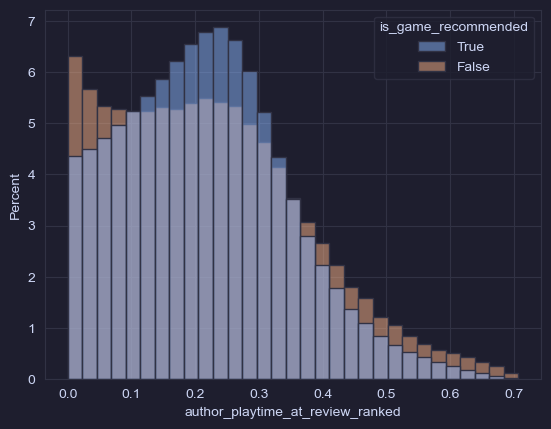

In [36]:
sns.histplot(
    pd.DataFrame(
        df_reviews.groupby(["author_steamid", "is_game_recommended"])[
            "author_playtime_at_review_ranked"
        ].std()
    ).dropna(),
    x="author_playtime_at_review_ranked",
    hue="is_game_recommended",
    hue_order=[True, False],
    stat="percent",
    bins="doane",
    common_norm=False,
)

plt.show()

In [ ]:
df_author_percentile_info = pd.DataFrame(
    df_reviews.groupby(["author_steamid", "is_game_recommended"])[
        "author_playtime_at_review_ranked"
    ].std()
).rename(columns={"author_playtime_at_review_ranked": "std"})
df_author_percentile_info["mean"] = df_reviews.groupby(
    ["author_steamid", "is_game_recommended"]
)["author_playtime_at_review_ranked"].mean()
df_author_percentile_info = df_author_percentile_info.dropna()
df_author_percentile_info = df_author_percentile_info.reset_index()

In [ ]:
df_author_percentile_info_unfiltered = pd.DataFrame(
    df_reviews.groupby(["author_steamid"])["author_playtime_at_review_ranked"].std()
).rename(columns={"author_playtime_at_review_ranked": "std"})
df_author_percentile_info_unfiltered["mean"] = df_reviews.groupby(["author_steamid"])[
    "author_playtime_at_review_ranked"
].mean()

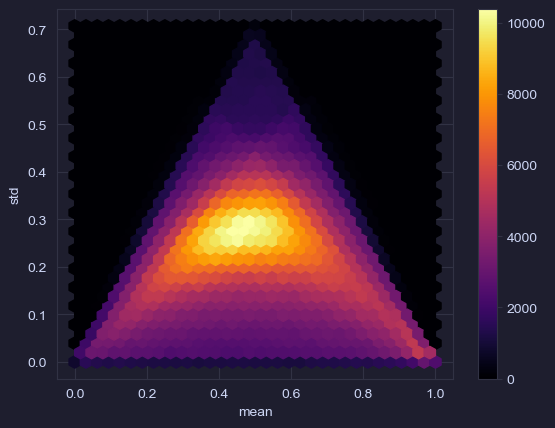

In [ ]:
plt.hexbin(
    x=df_author_percentile_info_unfiltered["mean"],
    y=df_author_percentile_info_unfiltered["std"],
    cmap="inferno",
    gridsize=32,
)

plt.ylabel("std")
plt.xlabel("mean")
plt.colorbar()
plt.show()

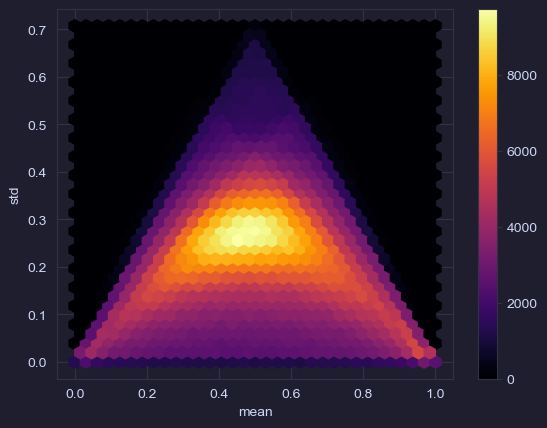

In [ ]:
plt.hexbin(
    x=df_author_percentile_info["mean"],
    y=df_author_percentile_info["std"],
    cmap="inferno",
    gridsize=32,
)

plt.ylabel("std")
plt.xlabel("mean")
plt.colorbar()
plt.show()

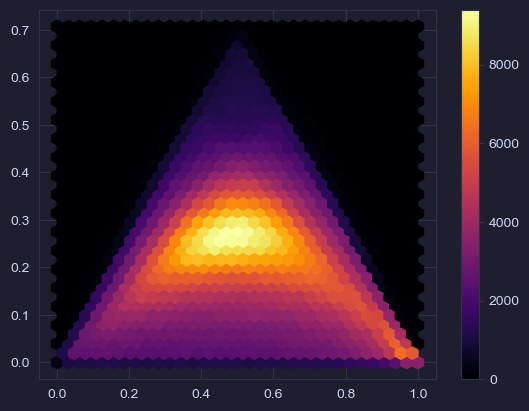

In [ ]:
plt.hexbin(
    x=df_author_percentile_info[df_author_percentile_info["is_game_recommended"]][
        "mean"
    ],
    y=df_author_percentile_info[df_author_percentile_info["is_game_recommended"]][
        "std"
    ],
    cmap="inferno",
    gridsize=32,
)

plt.colorbar()
plt.show()

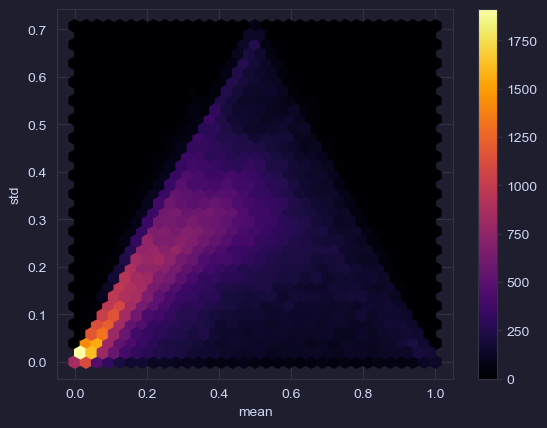

In [ ]:
plt.hexbin(
    x=df_author_percentile_info[
        df_author_percentile_info["is_game_recommended"] == False
    ]["mean"],
    y=df_author_percentile_info[
        df_author_percentile_info["is_game_recommended"] == False
    ]["std"],
    cmap="inferno",
    gridsize=32,
)

plt.ylabel("std")
plt.xlabel("mean")
plt.colorbar()
plt.show()

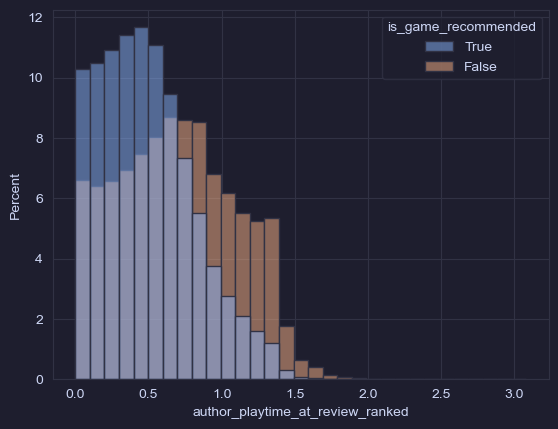

In [43]:
sns.histplot(
    pd.DataFrame(
        df_reviews.groupby(["author_steamid", "is_game_recommended"])[
            "author_playtime_at_review_ranked"
        ].std()
        / df_reviews.groupby(["author_steamid", "is_game_recommended"])[
            "author_playtime_at_review_ranked"
        ].mean()
    ).dropna(),
    x="author_playtime_at_review_ranked",
    hue="is_game_recommended",
    hue_order=[True, False],
    stat="percent",
    bins="doane",
    common_norm=False,
)

plt.show()

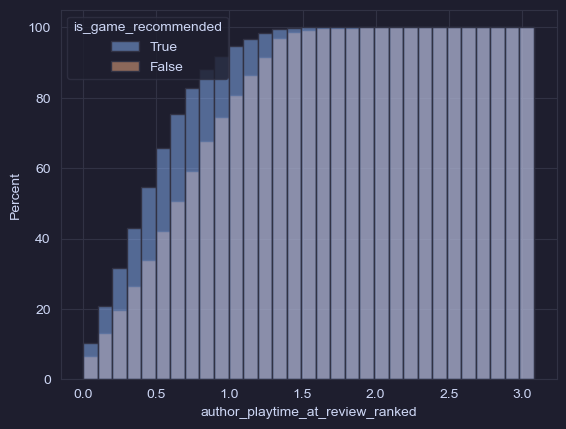

In [44]:
sns.histplot(
    pd.DataFrame(
        df_reviews.groupby(["author_steamid", "is_game_recommended"])[
            "author_playtime_at_review_ranked"
        ].std()
        / df_reviews.groupby(["author_steamid", "is_game_recommended"])[
            "author_playtime_at_review_ranked"
        ].mean()
    ).dropna(),
    x="author_playtime_at_review_ranked",
    hue="is_game_recommended",
    hue_order=[True, False],
    stat="percent",
    bins="doane",
    common_norm=False,
    cumulative=True,
)

plt.show()

In [ ]:
df_author_freq = pd.DataFrame(df_reviews["author_steamid"].value_counts().sort_values())

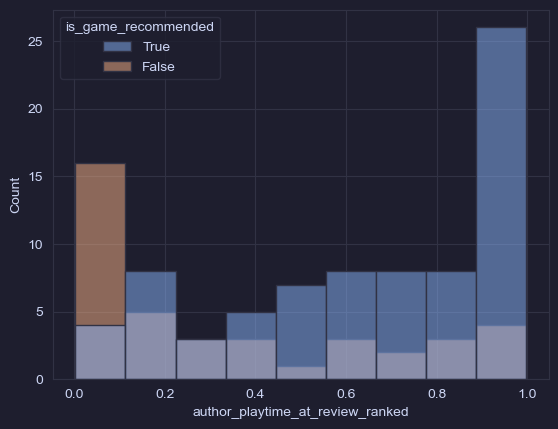

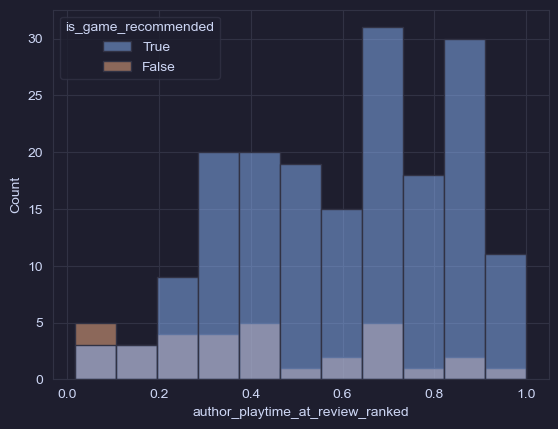

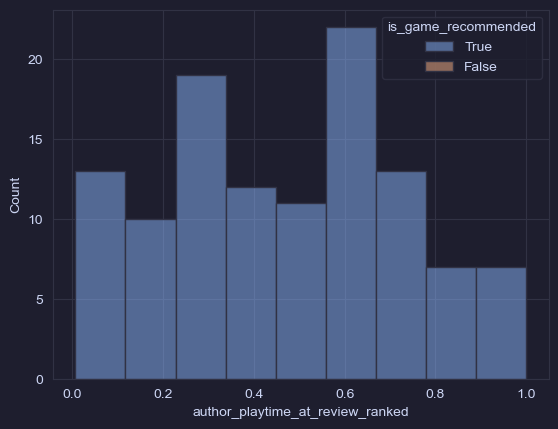

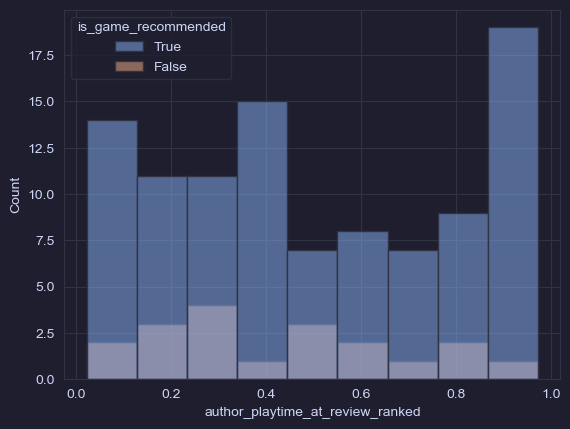

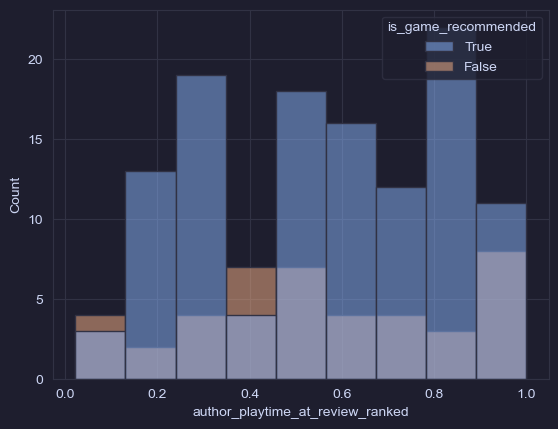

In [46]:
for author in (
    df_author_freq[df_author_freq["count"] > 100].sample(5, random_state=42).index
):

    sns.histplot(
        df_reviews[df_reviews["author_steamid"] == author],
        x="author_playtime_at_review_ranked",
        hue="is_game_recommended",
        hue_order=[True, False],
        bins="doane",
    )
    plt.show()

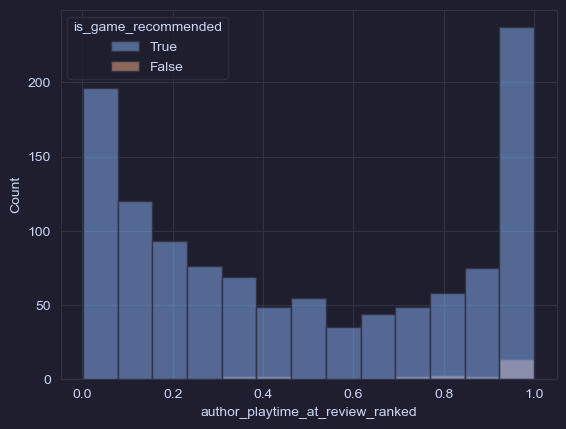

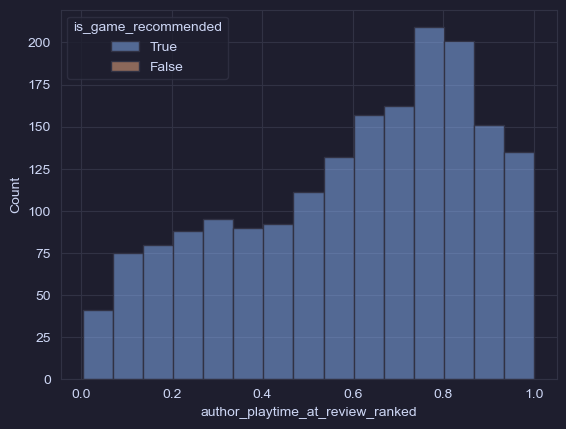

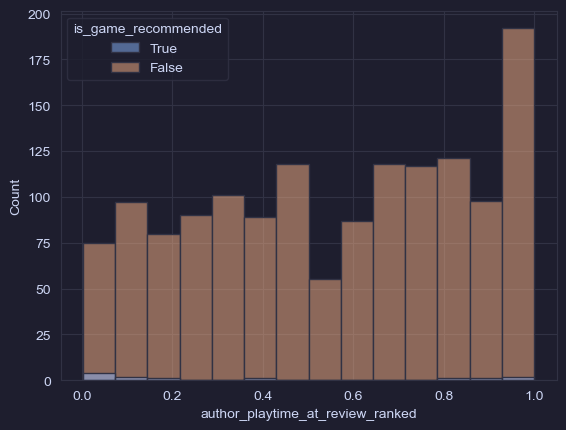

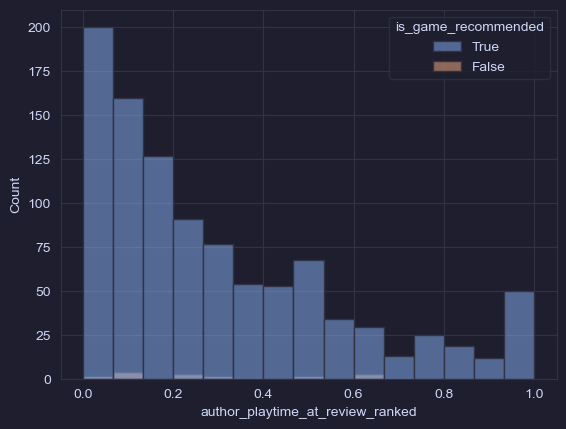

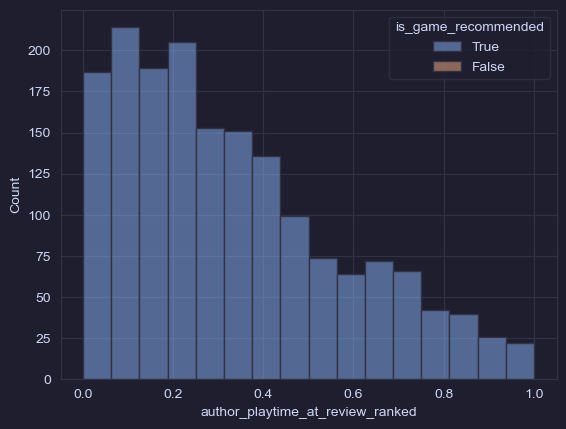

In [47]:
for author in (
    df_author_freq[df_author_freq["count"] > 1000].sample(5, random_state=42).index
):

    sns.histplot(
        df_reviews[df_reviews["author_steamid"] == author],
        x="author_playtime_at_review_ranked",
        hue="is_game_recommended",
        hue_order=[True, False],
        bins="doane",
    )
    plt.show()

In [48]:
for review in df_reviews[df_reviews["author_steamid"] == 76561199010042150].sample(
    5, random_state=42
)["review"]:
    print(review)

I am 32 years old.

My ex-wife and I have a daughter together, and we adopted our son together. Both are now 4 years old.

When we were going through our separation, I felt lost and unhappy. I was self-destructive. One day, I was so angry with everything spiraling out of control that I punched a concrete wall in a moment of overwhelming emotion. This resulted in breaking my fifth metacarpal in my right hand—the hand I worked with, played games with, and used to carry my children to bed—the hand I desperately needed to ensure I could continue providing.

Upon learning the severity of the self-inflicted damage, I became almost suicidal. Keep in mind that just a few months before this, I was the happiest man, with no history of depression or anxiety. I had never experienced anger outbursts, nor was I the type to break down and cry, but I was in a tough situation that truly prevented me from seeing the light on the other side.

With nothing better to do, I looked for a game I could play WI

In [ ]:
df_reviews["author_playtime_forever_ranked"] = df_reviews.groupby("steam_appid")[
    "author_playtime_forever"
].rank()
df_reviews["author_playtime_forever_ranked"] = (
    df_reviews["author_playtime_forever_ranked"] / df_reviews["reviews_per_game"]
)

In [ ]:
df_author_percentile_info = pd.DataFrame(
    df_reviews.groupby(["author_steamid", "is_game_recommended"])[
        "author_playtime_forever_ranked"
    ].std()
).rename(columns={"author_playtime_forever_ranked": "std"})
df_author_percentile_info["mean"] = df_reviews.groupby(
    ["author_steamid", "is_game_recommended"]
)["author_playtime_forever_ranked"].mean()
df_author_percentile_info = df_author_percentile_info.dropna()
df_author_percentile_info = df_author_percentile_info.reset_index()

In [ ]:
df_author_percentile_info_unfiltered = pd.DataFrame(
    df_reviews.groupby(["author_steamid"])["author_playtime_forever_ranked"].std()
).rename(columns={"author_playtime_forever_ranked": "std"})
df_author_percentile_info_unfiltered["mean"] = df_reviews.groupby(["author_steamid"])[
    "author_playtime_forever_ranked"
].mean()
df_author_percentile_info_unfiltered = df_author_percentile_info_unfiltered.dropna()
df_author_percentile_info_unfiltered = (
    df_author_percentile_info_unfiltered.reset_index()
)

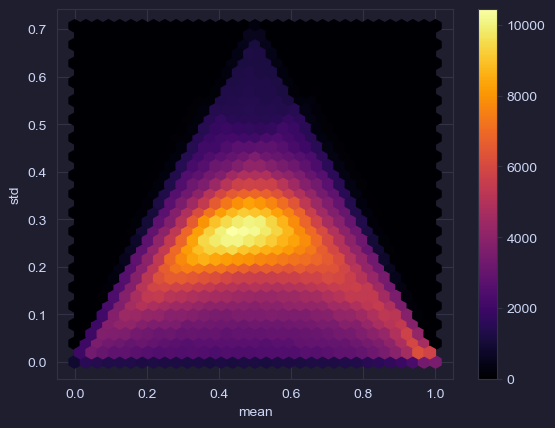

In [52]:
plt.hexbin(
    x=df_author_percentile_info_unfiltered["mean"],
    y=df_author_percentile_info_unfiltered["std"],
    cmap="inferno",
    gridsize=32,
)

plt.ylabel("std")
plt.xlabel("mean")
plt.colorbar()
plt.show()

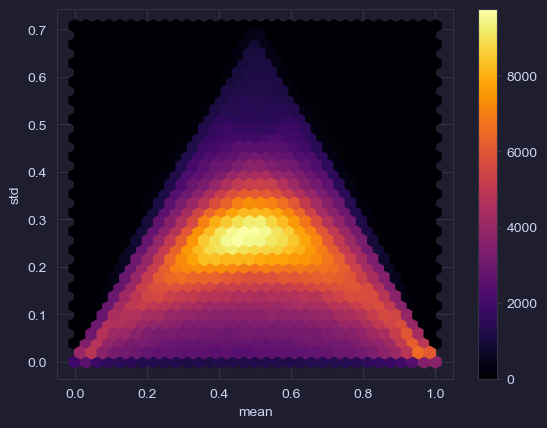

In [53]:
plt.hexbin(
    x=df_author_percentile_info["mean"],
    y=df_author_percentile_info["std"],
    cmap="inferno",
    gridsize=32,
)

plt.ylabel("std")
plt.xlabel("mean")
plt.colorbar()
plt.show()

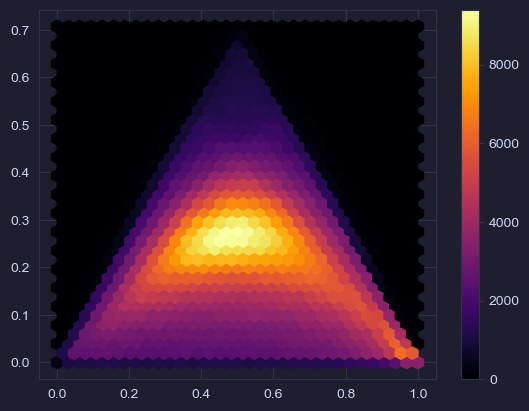

In [54]:
plt.hexbin(
    x=df_author_percentile_info[df_author_percentile_info["is_game_recommended"]][
        "mean"
    ],
    y=df_author_percentile_info[df_author_percentile_info["is_game_recommended"]][
        "std"
    ],
    cmap="inferno",
    gridsize=32,
)

plt.colorbar()
plt.show()

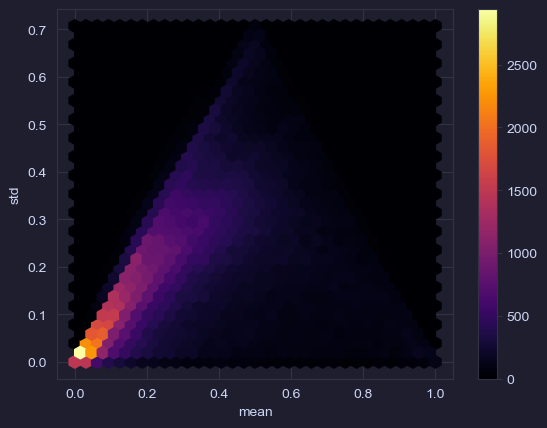

In [55]:
plt.hexbin(
    x=df_author_percentile_info[
        df_author_percentile_info["is_game_recommended"] == False
    ]["mean"],
    y=df_author_percentile_info[
        df_author_percentile_info["is_game_recommended"] == False
    ]["std"],
    cmap="inferno",
    gridsize=32,
)

plt.ylabel("std")
plt.xlabel("mean")
plt.colorbar()
plt.show()

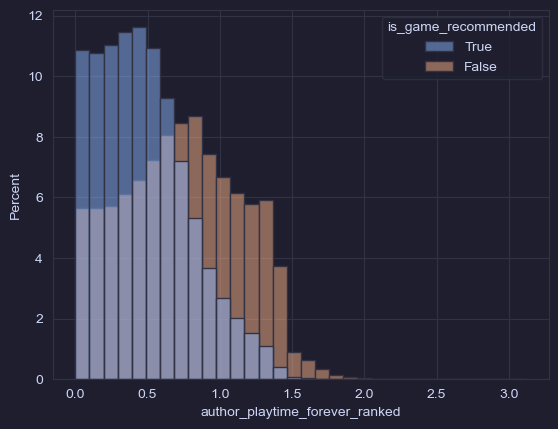

In [56]:
sns.histplot(
    pd.DataFrame(
        df_reviews.groupby(["author_steamid", "is_game_recommended"])[
            "author_playtime_forever_ranked"
        ].std()
        / df_reviews.groupby(["author_steamid", "is_game_recommended"])[
            "author_playtime_forever_ranked"
        ].mean()
    ).dropna(),
    x="author_playtime_forever_ranked",
    hue="is_game_recommended",
    hue_order=[True, False],
    stat="percent",
    bins="doane",
    common_norm=False,
)

plt.show()

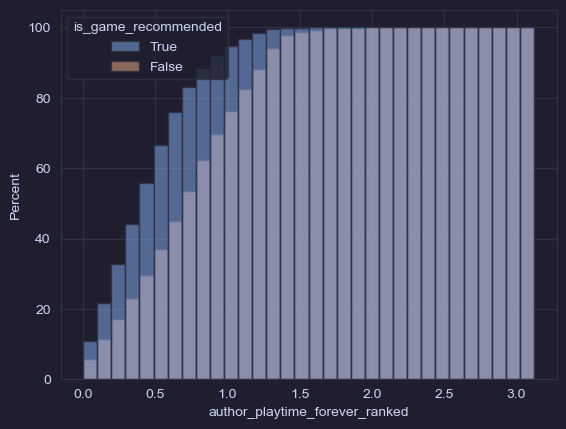

In [57]:
sns.histplot(
    pd.DataFrame(
        df_reviews.groupby(["author_steamid", "is_game_recommended"])[
            "author_playtime_forever_ranked"
        ].std()
        / df_reviews.groupby(["author_steamid", "is_game_recommended"])[
            "author_playtime_forever_ranked"
        ].mean()
    ).dropna(),
    x="author_playtime_forever_ranked",
    hue="is_game_recommended",
    hue_order=[True, False],
    stat="percent",
    bins="doane",
    common_norm=False,
    cumulative=True,
)

plt.show()

In [ ]:
df_author_freq = pd.DataFrame(df_reviews["author_steamid"].value_counts().sort_values())

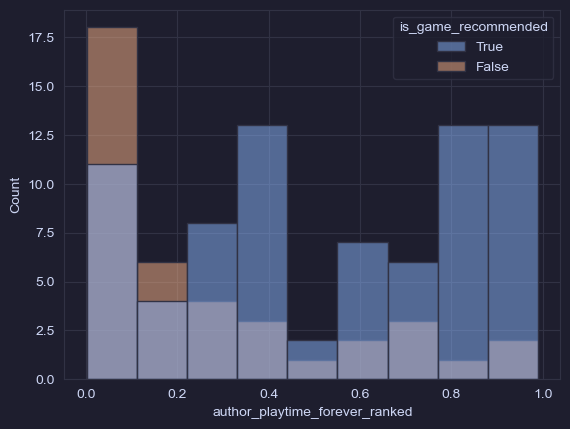

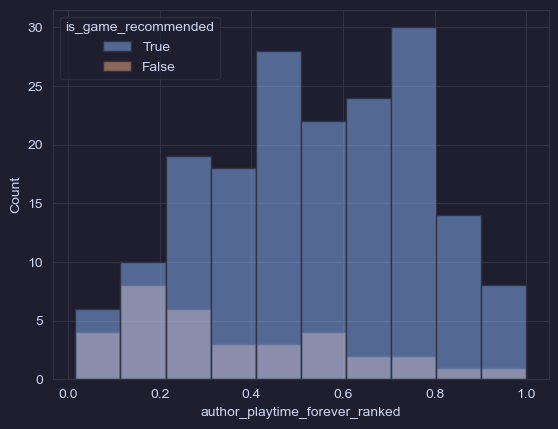

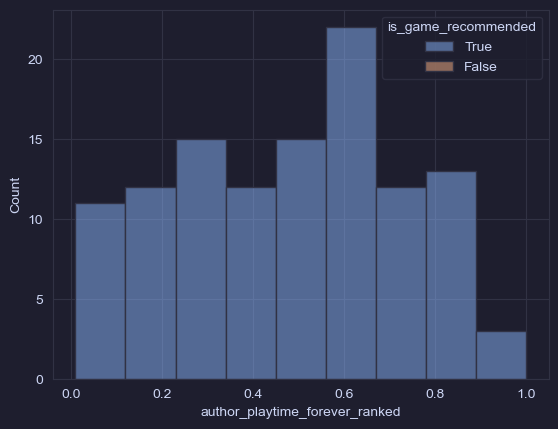

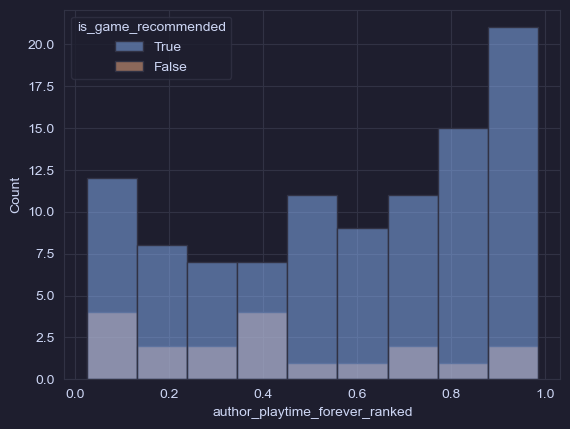

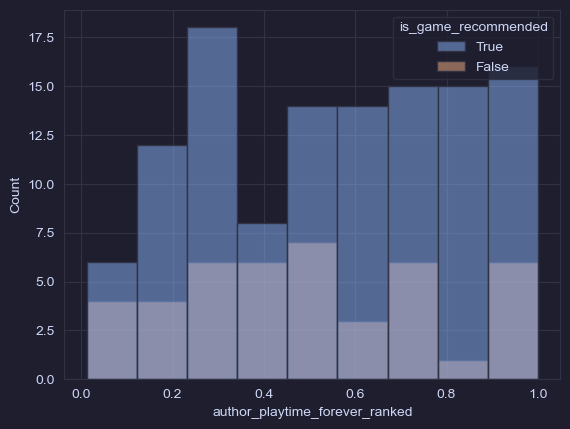

In [59]:
for author in (
    df_author_freq[df_author_freq["count"] > 100].sample(5, random_state=42).index
):

    sns.histplot(
        df_reviews[df_reviews["author_steamid"] == author],
        x="author_playtime_forever_ranked",
        hue="is_game_recommended",
        hue_order=[True, False],
        bins="doane",
    )
    plt.show()

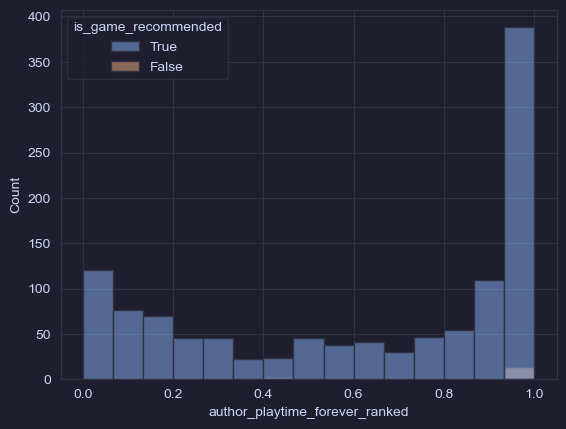

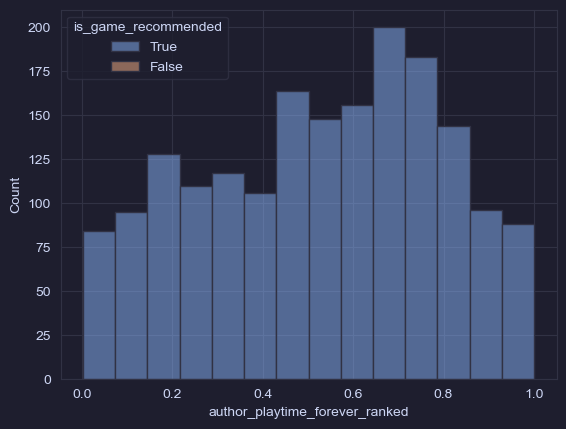

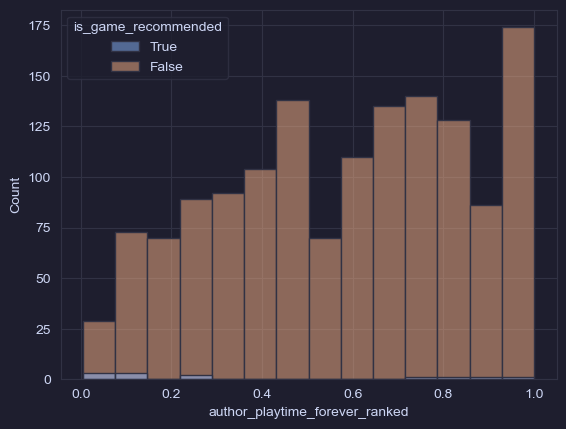

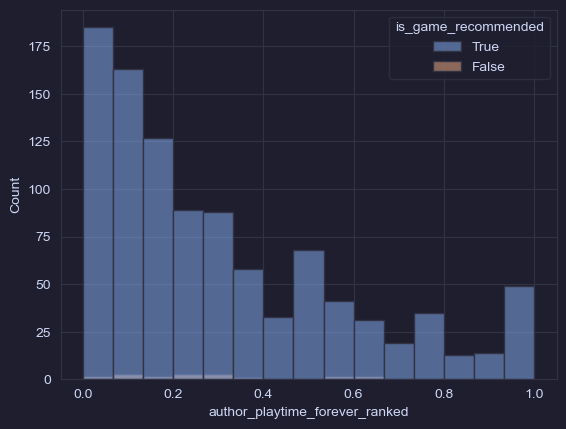

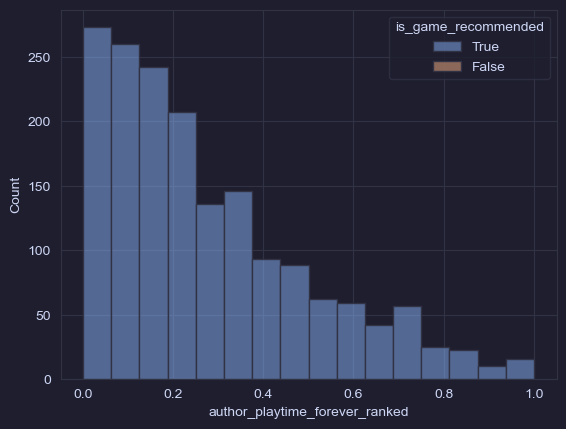

In [60]:
for author in (
    df_author_freq[df_author_freq["count"] > 1000].sample(5, random_state=42).index
):

    sns.histplot(
        df_reviews[df_reviews["author_steamid"] == author],
        x="author_playtime_forever_ranked",
        hue="is_game_recommended",
        hue_order=[True, False],
        bins="doane",
    )
    plt.show()